# Option Pricing path testing

In [46]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import gmean

from src.evaluate import metrics as m
from src.visualization import plot_option_results as por

In [47]:
# Import csv
method = "GBM"
n_paths = 100
freq = "Y"
name_string = f"_{method}_{n_paths}_{freq}.csv"
n_periods = 1/12 if freq == "M" else 1
mu = 0.05
sigma = 0.2

recovered_paths_df = pd.read_csv("csv_export/recovered_paths" + name_string) + 1
underlying_paths_df = pd.read_csv("csv_export/mg_windows" + name_string) + 1

recovered_paths_df.columns = np.linspace(0, n_periods, recovered_paths_df.shape[1])
underlying_paths_df.columns = np.linspace(0, n_periods, recovered_paths_df.shape[1])

In [48]:
# # Test first half of each path
# denominator = 21 if freq == "M" else 252
# n_periods *= (recovered_paths_df.shape[1]//2 / denominator)
# recovered_paths_df = recovered_paths_df.iloc[:,:(recovered_paths_df.shape[1]//2+1)]
# underlying_paths_df = underlying_paths_df.iloc[:,:(underlying_paths_df.shape[1]//2+1)]

In [49]:

m.print_basic_gbm_metrics(
    n_periods = n_periods, 
    annualization_factor = (underlying_paths_df.shape[1]-1)/n_periods, 
    ground_paths_df = underlying_paths_df, 
    recovered_paths_df = recovered_paths_df, 
    exp_stdev = sigma,  
    mu = mu,  
    return_threshold = 0.015
)

Generated mean:	 0.99220
Input mean:	 1.04433
Expected mean:	 1.05127
-------------------------------------
Ann. gen stdev:	 0.09850
Ann. pat stdev:	 0.20053
Exp. stdev:	 0.20000
-------------------------------------
ul % > 1.50%:	 23.62698
gen % > 1.50%:	 0.04409


## Plots

In [50]:
# Parameters
S0 = 1
r = mu
T = n_periods
t = 0
K_grid = np.linspace(0.5, 1.5, 100)

### European Options

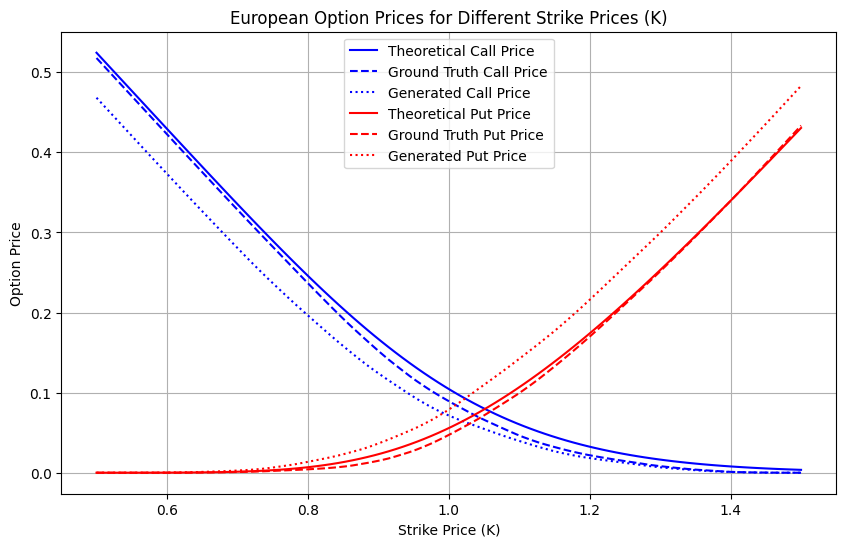

In [51]:
def exact_european_prices(K):
    d1 = (np.log(S0/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
    exact_call = S0*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)
    exact_put = K*np.exp(-r*(T-t)) - S0 + exact_call
    return exact_call, exact_put

european_call = lambda x,K: np.maximum(x.iloc[:, -1] - K, 0)
european_put = lambda x,K: np.maximum(K - x.iloc[:, -1], 0)

exact_call_prices, exact_put_prices, mc_call_ground_prices, \
mc_put_ground_prices, mc_call_gen_prices, mc_put_gen_prices = por.plot_option_prices_K(
    ground_paths_df = underlying_paths_df, 
    gen_paths_df = recovered_paths_df, 
    K_values = K_grid, 
    exact_call_put = exact_european_prices, 
    call_payoff = european_call, 
    put_payoff = european_put,
    r = mu, 
    T = n_periods
)

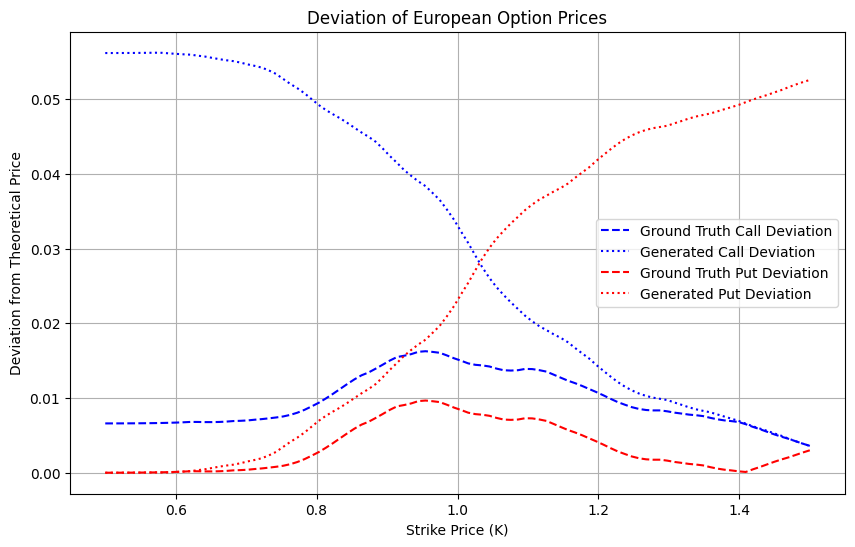

In [52]:
ground_call_deviations, ground_put_deviations, \
gen_call_deviations, gen_put_deviations = por.plot_option_price_deviation_absolute(
    mc_call_ground_prices=mc_call_ground_prices, 
    mc_put_ground_prices=mc_put_ground_prices, 
    mc_call_gen_prices=mc_call_gen_prices, 
    mc_put_gen_prices=mc_put_gen_prices, 
    exact_call_prices=exact_call_prices, 
    exact_put_prices=exact_put_prices, 
    x_values=K_grid
)


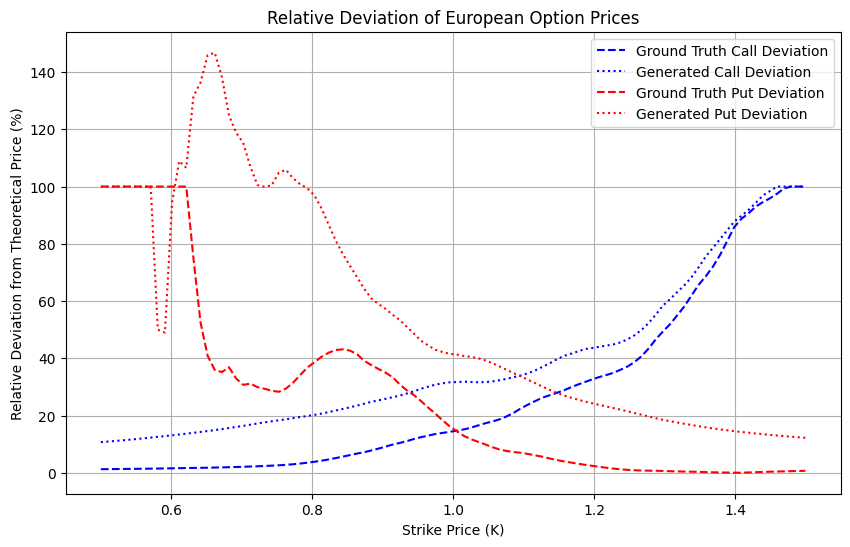

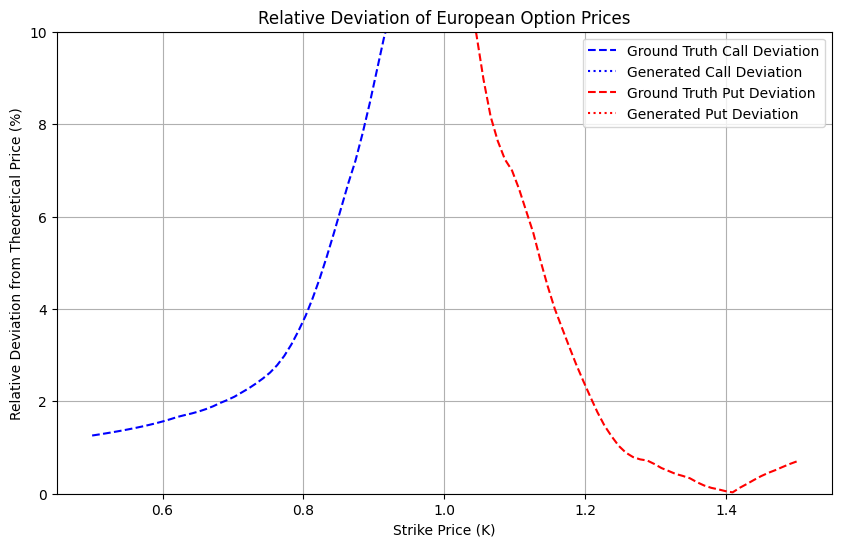

In [53]:
ground_call_deviations_rel, ground_put_deviations_rel, \
gen_call_deviations_rel, gen_put_deviations_rel = por.plot_option_price_deviation_relative(
    ground_call_deviations=ground_call_deviations, 
    ground_put_deviations=ground_put_deviations, 
    gen_call_deviations=gen_call_deviations, 
    gen_put_deviations=gen_put_deviations, 
    exact_call_prices=exact_call_prices, 
    exact_put_prices=exact_put_prices, 
    x_values=K_grid
)

### Lookback Options

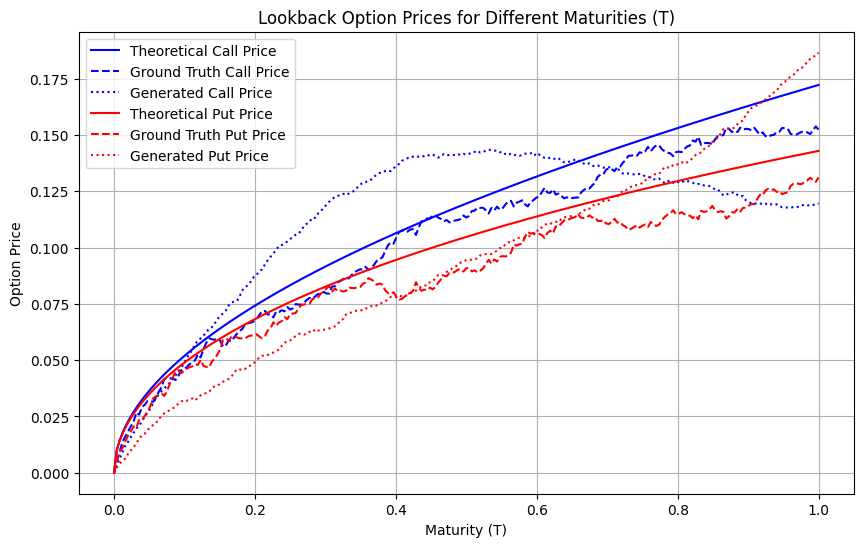

In [54]:
def exact_lookback_prices(T_cur):
    d = (r + sigma**2/2)*np.sqrt(T_cur-t)/sigma
    exact_call = S0*(
        norm.cdf(d) - 
        np.exp(-r*(T_cur-t))*norm.cdf(d-sigma*np.sqrt(T_cur-t)) - 
        sigma**2/(2*r)*norm.cdf(-d) +
        np.exp(-r*(T_cur-t))*sigma**2/(2*r)*norm.cdf(d-sigma*np.sqrt(T_cur-t))
    )
    exact_put = S0*(
        -norm.cdf(-d) + 
        np.exp(-r*(T_cur-t))*norm.cdf(-d+sigma*np.sqrt(T_cur-t)) +
        sigma**2/(2*r)*norm.cdf(d) -
        np.exp(-r*(T_cur-t))*sigma**2/(2*r)*norm.cdf(-d+sigma*np.sqrt(T_cur-t))
    )
    return exact_call, exact_put

lookback_call = lambda x: np.maximum(x.iloc[:, -1] - x.min(axis=1), 0)
lookback_put = lambda x: np.maximum(x.max(axis=1) - x.iloc[:, -1], 0)

exact_call_prices, exact_put_prices, mc_call_ground_prices, mc_put_ground_prices, \
mc_call_gen_prices, mc_put_gen_prices, T_values = por.plot_option_prices_T(
    ground_paths_df = underlying_paths_df, 
    gen_paths_df = recovered_paths_df, 
    exact_call_put = exact_lookback_prices, 
    call_payoff = lookback_call, 
    put_payoff = lookback_put,
    r = mu,     
    T = n_periods,
    grid_size = 1,
    title_prefix="Lookback "
)

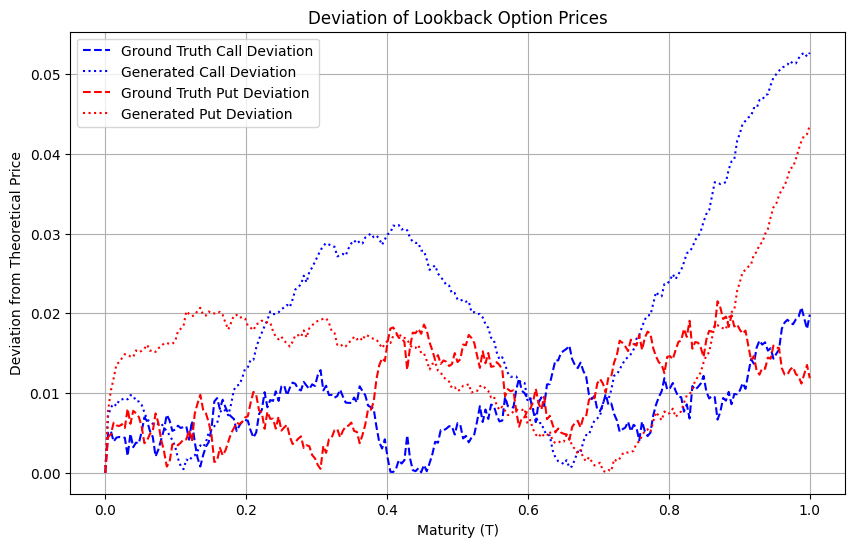

In [55]:
ground_call_deviations, ground_put_deviations, \
gen_call_deviations, gen_put_deviations = por.plot_option_price_deviation_absolute(
    mc_call_ground_prices=mc_call_ground_prices, 
    mc_put_ground_prices=mc_put_ground_prices, 
    mc_call_gen_prices=mc_call_gen_prices, 
    mc_put_gen_prices=mc_put_gen_prices, 
    exact_call_prices=exact_call_prices, 
    exact_put_prices=exact_put_prices, 
    x_values=T_values,
    x_label="Maturity (T)",
    title_prefix="Lookback " 
)


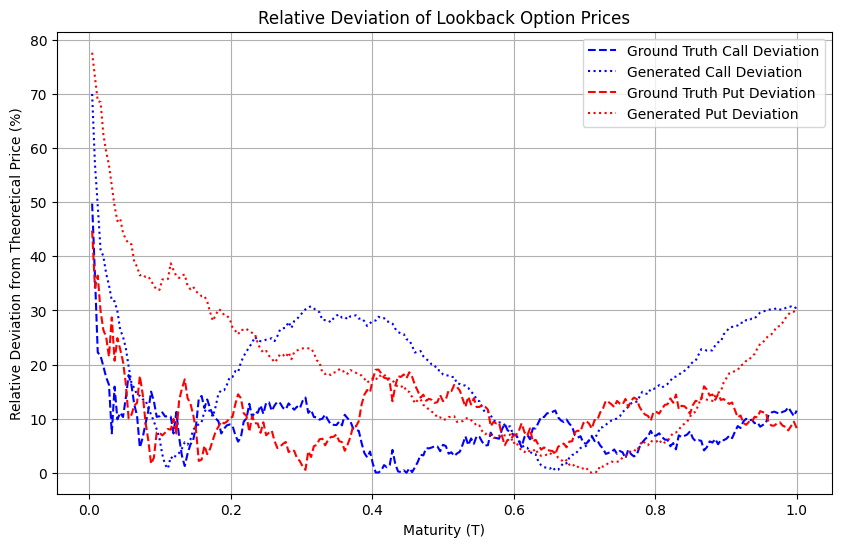

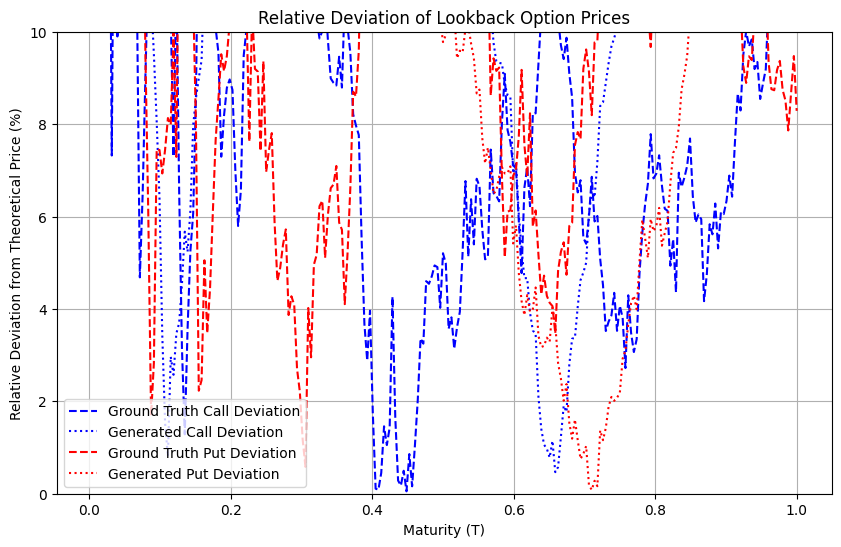

In [56]:
ground_call_deviations_rel, ground_put_deviations_rel, \
gen_call_deviations_rel, gen_put_deviations_rel = por.plot_option_price_deviation_relative(
    ground_call_deviations=ground_call_deviations[1:], # skip first value to avoid division by zero
    ground_put_deviations=ground_put_deviations[1:], 
    gen_call_deviations=gen_call_deviations[1:], 
    gen_put_deviations=gen_put_deviations[1:], 
    exact_call_prices=exact_call_prices[1:], 
    exact_put_prices=exact_put_prices[1:], 
    x_values=T_values[1:],
    x_label="Maturity (T)",
    title_prefix="Lookback "
)

### Asian (Geometric)

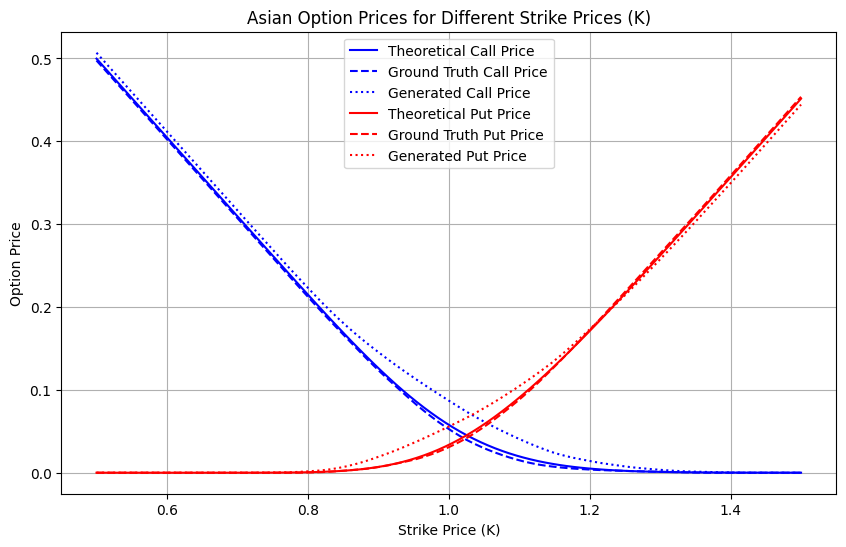

In [57]:
def exact_asian_prices(K):
    M1 = (np.exp(r*T)-1)/(r*T)*S0
    M2 = (
        2*np.exp((2*r+sigma**2)*T)*S0**2 / ((r+sigma**2)*(2*r+sigma**2)*T**2) + 
        2*S0**2 / (r*T**2) * (1/(2*r+sigma**2) - np.exp(r*T)/(r+sigma**2))
    )
    sigma_tilde = np.sqrt(np.log(M2/M1**2)/T)
    d1 = (np.log(M1/K) + sigma_tilde**2*T/2) / (sigma_tilde*np.sqrt(T))
    d2 = d1 - sigma_tilde*np.sqrt(T)

    exact_call = np.exp(-r*T)*(M1*norm.cdf(d1) - K*norm.cdf(d2))
    exact_put = np.exp(-r*T)*(K*norm.cdf(-d2) - M1*norm.cdf(-d1))

    return exact_call, exact_put

asian_call = lambda x,K: np.maximum(x.apply(gmean, axis=1) - K, 0)
asian_put = lambda x,K: np.maximum(K - x.apply(gmean, axis=1), 0)

exact_call_prices, exact_put_prices, mc_call_ground_prices, \
mc_put_ground_prices, mc_call_gen_prices, mc_put_gen_prices = por.plot_option_prices_K(
    ground_paths_df = underlying_paths_df, 
    gen_paths_df = recovered_paths_df, 
    K_values = K_grid, 
    exact_call_put = exact_asian_prices, 
    call_payoff = asian_call, 
    put_payoff = asian_put,
    r = mu, 
    T = n_periods,
    title_prefix="Asian "
)

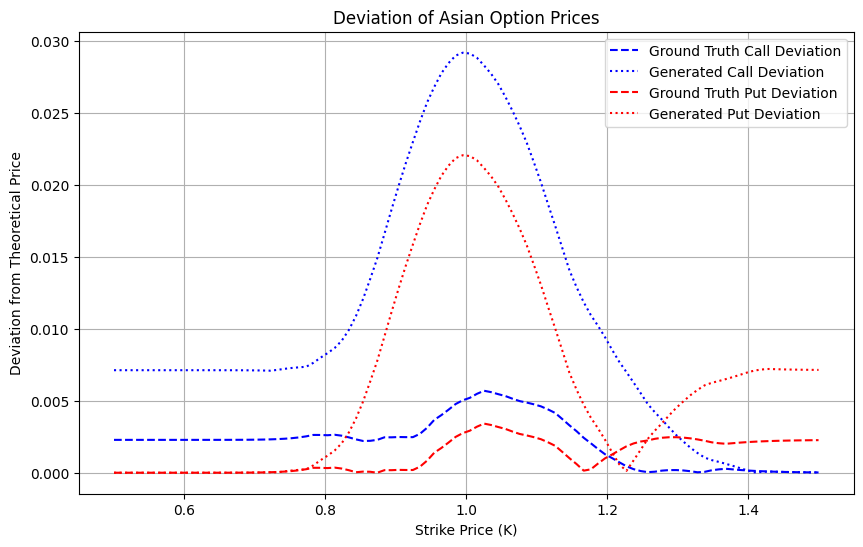

In [58]:
ground_call_deviations, ground_put_deviations, \
gen_call_deviations, gen_put_deviations = por.plot_option_price_deviation_absolute(
    mc_call_ground_prices=mc_call_ground_prices, 
    mc_put_ground_prices=mc_put_ground_prices, 
    mc_call_gen_prices=mc_call_gen_prices, 
    mc_put_gen_prices=mc_put_gen_prices, 
    exact_call_prices=exact_call_prices, 
    exact_put_prices=exact_put_prices, 
    x_values=K_grid,
    title_prefix="Asian "
)

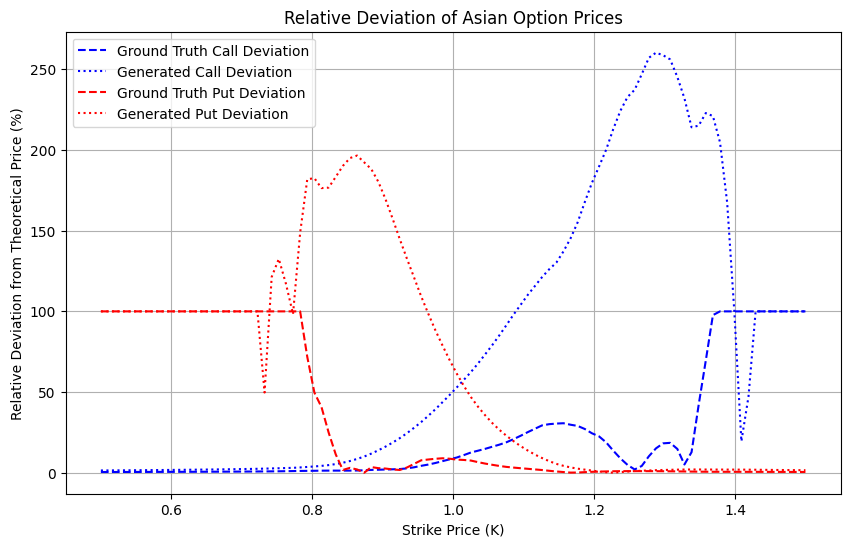

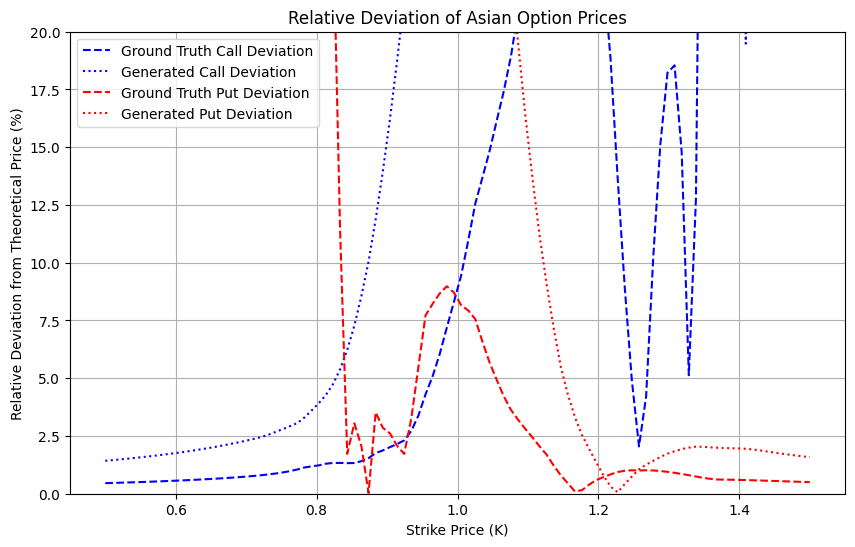

In [59]:
ground_call_deviations_rel, ground_put_deviations_rel, \
gen_call_deviations_rel, gen_put_deviations_rel = por.plot_option_price_deviation_relative(
    ground_call_deviations=ground_call_deviations, 
    ground_put_deviations=ground_put_deviations, 
    gen_call_deviations=gen_call_deviations, 
    gen_put_deviations=gen_put_deviations, 
    exact_call_prices=exact_call_prices, 
    exact_put_prices=exact_put_prices, 
    x_values=K_grid,
    title_prefix="Asian ",
    zoom_ylimits=(0, 20)
)

## Latex Export

In [60]:
# K values to loop over 
K_values = np.concatenate((np.linspace(0.8, 0.95, 4), np.linspace(0.96, 1.05, 10), np.linspace(1.1, 1.25, 4)))

# Store results
results = []

for K in K_values:
    d1 = (np.log(S0/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)

    exact_call_price = S0*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)
    exact_put_price = K*np.exp(-r*(T-t)) - S0 + exact_call_price

    mc_call_gen_price = np.mean(np.exp(-r*(T-t))*np.maximum(recovered_paths_df.iloc[:, -1] - K, 0))
    mc_call_ul_price = np.mean(np.exp(-r*(T-t))*np.maximum(underlying_paths_df.iloc[:, -1] - K, 0))

    mc_put_gen_price = np.mean(np.exp(-r*(T-t))*np.maximum(K - recovered_paths_df.iloc[:, -1], 0))
    mc_put_ul_price = np.mean(np.exp(-r*(T-t))*np.maximum(K - underlying_paths_df.iloc[:, -1], 0))

    gen_call_deviation = mc_call_gen_price - exact_call_price 
    ul_call_deviation = mc_call_ul_price - exact_call_price

    gen_put_deviation = mc_put_gen_price - exact_put_price
    ul_put_deviation = mc_put_ul_price - exact_put_price

    results.append([
        K, 
        exact_call_price, 
        mc_call_gen_price, 
        gen_call_deviation, 
        mc_call_ul_price, 
        ul_call_deviation,
        exact_put_price,
        mc_put_gen_price, 
        gen_put_deviation, 
        mc_put_ul_price, 
        ul_put_deviation
    ])

# Create LaTeX table
latex_table = """
\\begin{table}[H]
\\centering
\\begin{tabular}{
""" 
latex_table += "|C{0.8cm}||C{1.7cm}|C{1.8cm}C{0cm}|C{1.8cm}C{0cm}||C{1.7cm}|C{1.8cm}C{0cm}|C{1.8cm}C{0cm}|}\n"
latex_table += """
\\hline
$K$ & Exact Call Price & Gen Call Price & & UL Call Price & & Exact Put Price & Gen Put Price & & UL Put Price & \\\\
\\hline
"""

for row in results:
    latex_table += " & ".join(
        [
            f"{row[i]:.2f}" if i==0 else 
            f"{row[i]:.6f}" if i==1 or i==6 else 
            "" if i==3 or i==5 or i==8 or i==10 else
            f"{row[i]:.6f} ({row[i+1]:.4f})" for i in range(len(row))
        ]
    ) + " \\\\ \\hline \n"

latex_table += "\n\\end{tabular}\n\\caption{Option Prices and Deviations}\n\\label{tab:option_prices}\n\\end{table}"

print(latex_table)



\begin{table}[H]
\centering
\begin{tabular}{
|C{0.8cm}||C{1.7cm}|C{1.8cm}C{0cm}|C{1.8cm}C{0cm}||C{1.7cm}|C{1.8cm}C{0cm}|C{1.8cm}C{0cm}|}

\hline
$K$ & Exact Call Price & Gen Call Price & & UL Call Price & & Exact Put Price & Gen Put Price & & UL Put Price & \\
\hline
0.80 & 0.245888 & 0.196426 (-0.0495) &  & 0.236675 (-0.0092) &  & 0.006872 & 0.013602 (0.0067) &  & 0.004261 (-0.0026) &  \\ \hline 
0.85 & 0.204693 & 0.158275 (-0.0464) &  & 0.192425 (-0.0123) &  & 0.013238 & 0.023012 (0.0098) &  & 0.007572 (-0.0057) &  \\ \hline 
0.90 & 0.166994 & 0.124206 (-0.0428) &  & 0.152210 (-0.0148) &  & 0.023101 & 0.036504 (0.0134) &  & 0.014918 (-0.0082) &  \\ \hline 
0.95 & 0.133465 & 0.094811 (-0.0387) &  & 0.117206 (-0.0163) &  & 0.037133 & 0.054671 (0.0175) &  & 0.027476 (-0.0097) &  \\ \hline 
0.96 & 0.127300 & 0.089415 (-0.0379) &  & 0.111060 (-0.0162) &  & 0.040480 & 0.058787 (0.0183) &  & 0.030842 (-0.0096) &  \\ \hline 
0.97 & 0.121320 & 0.084322 (-0.0370) &  & 0.105172 (-0.0161) &  & 